In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [44]:
class CircleDataset(Dataset):
    def __init__(self, n_samples=1000):
        
        self.X = np.random.uniform(low=-1.5, high=1.5, size=(n_samples, 2))
        
        
        distance_from_origin = np.sqrt(self.X[:,0]**2 + self.X[:,1]**2)
        
        
        self.y = (distance_from_origin < 1).astype(np.float32)
        
        
        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32)
        
        
        print(f"Generated {n_samples} samples")
        print(f"Number of points inside circle: {int(self.y.sum())}")
        print(f"Number of points outside circle: {n_samples - int(self.y.sum())}")
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


dataset = CircleDataset(n_samples=1000)

Generated 1000 samples
Number of points inside circle: 358
Number of points outside circle: 642


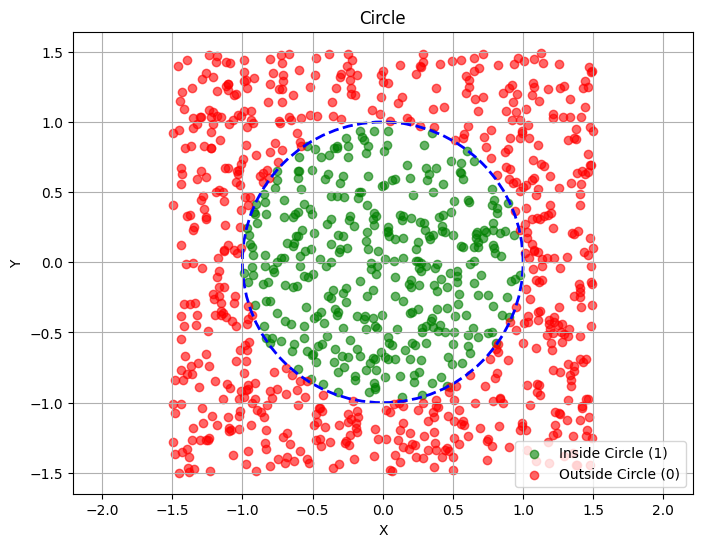

In [45]:
def plot_data(dataset):
    X = dataset.X.numpy()
    y = dataset.y.numpy()
    
    plt.figure(figsize=(8, 6))
    
    # Plot points inside circle (label 1)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], color='green', label='Inside Circle (1)', alpha=0.6)
    
    # Plot points outside circle (label 0)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', label='Outside Circle (0)', alpha=0.6)
    
    # Draw the actual circle for reference
    circle = plt.Circle((0, 0), 1, color='blue', fill=False, linestyle='--', linewidth=2)
    plt.gca().add_patch(circle)
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Circle')
    plt.legend()
    plt.axis('equal')
    plt.grid(True)
    plt.show()

plot_data(dataset)

In [46]:

class Circleclassify(nn.Module):
    def __init__(self):
        super(Circleclassify, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(5, 3),
            nn.ReLU(),
            nn.Linear(3, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x_squared = x[:, 0:1]**2
        y_squared = x[:, 1:2]**2
        distance = torch.sqrt(x_squared + y_squared)

        eng_feat = torch.cat([x, x_squared, y_squared, distance], dim=1)
        out = self.network(eng_feat) 
        return out


model = Circleclassify()
print(model)

Circleclassify(
  (network): Sequential(
    (0): Linear(in_features=5, out_features=3, bias=True)
    (1): ReLU()
    (2): Linear(in_features=3, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


In [47]:

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

Training samples: 800
Testing samples: 200


In [ ]:

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train_losses = []

In [49]:
# Number of training passes through the entire dataset
num_epochs = 100

for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    # Training loop
    for batch_X, batch_y in train_loader:
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        predictions = model(batch_X)
        
        # Calculate loss
        loss = criterion(predictions.squeeze(), batch_y)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches
    train_losses.append(avg_loss)
    
    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

print("Training completed!")

Epoch [10/100], Loss: 0.0884
Epoch [20/100], Loss: 0.0548
Epoch [30/100], Loss: 0.0469
Epoch [40/100], Loss: 0.0380
Epoch [50/100], Loss: 0.0313
Epoch [60/100], Loss: 0.0291
Epoch [70/100], Loss: 0.0274
Epoch [80/100], Loss: 0.0244
Epoch [90/100], Loss: 0.0248
Epoch [100/100], Loss: 0.0226
Training completed!


In [50]:
# Set model to evaluation mode
model.eval()

correct = 0
total = 0

with torch.no_grad():  # No need to calculate gradients for evaluation
    for test_X, test_y in test_loader:
        predictions = model(test_X)
        predicted_labels = (predictions.squeeze() > 0.5).float()  # Convert probabilities to 0/1
        
        correct += (predicted_labels == test_y).sum().item()
        total += test_y.size(0)

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 100.00%


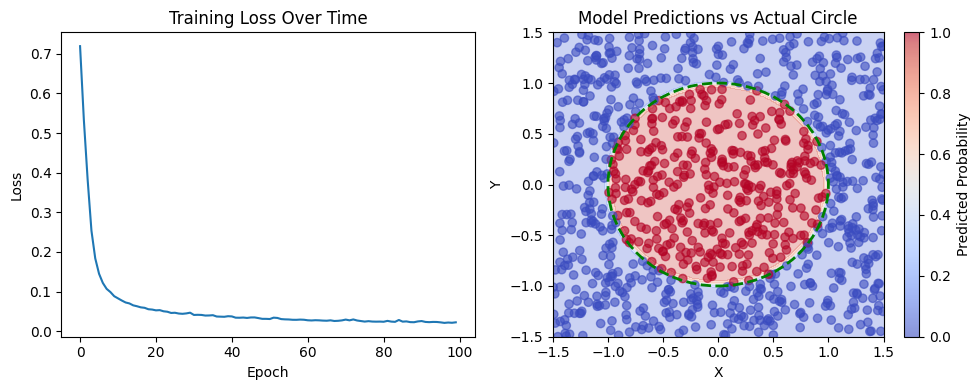

In [51]:
# Plot training loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')

# Plot decision boundary
plt.subplot(1, 2, 2)
xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 100), np.linspace(-1.5, 1.5, 100))
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.tensor(grid_points, dtype=torch.float32)

model.eval()
with torch.no_grad():
    grid_pred = model(grid_tensor).numpy().reshape(xx.shape)

plt.contourf(xx, yy, grid_pred, alpha=0.3, cmap='coolwarm')
plt.scatter(dataset.X.numpy()[:, 0], dataset.X.numpy()[:, 1], 
            c=dataset.y.numpy(), cmap='coolwarm', alpha=0.6)
circle = plt.Circle((0, 0), 1, color='green', fill=False, linestyle='--', linewidth=2)
plt.gca().add_patch(circle)
plt.title('Model Predictions vs Actual Circle')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(label='Predicted Probability')
plt.tight_layout()
plt.show()